In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import matplotlib
from matplotlib import animation
from importlib import reload
from cycler import cycler
# source modules and classes being developed 
from package.writhe.writhe import running_mean
import nmrglue

 # Spectral decompositions - NMR

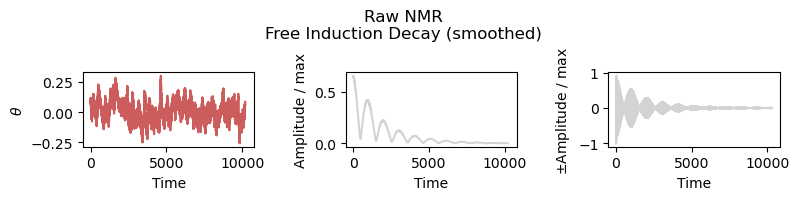

In [82]:
%matplotlib inline
dic, fid = nmrglue.varian.read("/home/t/Downloads/ALA_FID/L_ALANINE_PRESAT.FID")

to_cart = lambda phase, amp : (amp * np.cos(phase),  amp * np.sin(phase))

stride = 1
amp, phase = np.abs(fid), np.angle(fid)

amp /= amp.max()

amp, phase = (i[::stride] for i in (amp, phase))

amp_smooth, phase_smooth = [running_mean(i, 100) for i in (amp, phase)]

fig, axes = plt.subplots(1, 3, figsize=(8, 2), sharex=True)
ax = axes.flat
ax[0].plot(phase_smooth, color="indianred")
ax[0].set_ylabel(r"$\theta$")
ax[0].set_xlabel("Time")
ax[1].plot(amp_smooth, color="lightgray")
ax[1].set_ylabel(r"Amplitude / max")
ax[1].set_xlabel("Time")
ax[2].plot(amp * np.sign(phase), color="lightgray")
ax[2].set_ylabel(r"$\pm$Amplitude / max")
ax[2].set_xlabel("Time")
fig.suptitle("Raw NMR\nFree Induction Decay (smoothed)")
fig.tight_layout()

 # We observe phase coherence in the transverse (xy) plane (bottom row in diagram);
 ## The decoherence (spin-spin 'decorrelation') is characterized by T2 relaxation

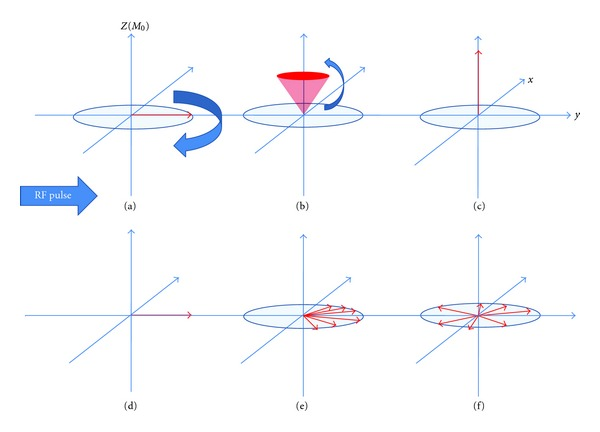

Let's make this perspective for our data.
We start with a time series of complex numbers (FID)

for a complex number,  $\ c = a + bi$
 ##### Polar coordinates
 $phase : \theta  = tan^{-1} (\frac{b}{a})$
 
 $amplitude : r = (a^{2} + b^{2})^{\frac{1}{2}}$
 
 $e^{ir\theta} = r(cos\theta + isin\theta)$

In [355]:
phase, amp = (i[:4000] for i in (phase, amp))

x, y = to_cart(phase, amp)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# s = ax.scatter(phase[0], amp[0])# only plot needs zero index

p = ax.plot(phase[0], amp[0], lw=1, color="red")[0]

v = ax.quiver(0, 0, x[0], y[0],
              scale_units="inches",
              scale=.55,
              capstyle="butt")
ax.set_xlabel(r"$I_{m}$", labelpad=5, size=20)
ax.set_ylabel(r"$R_{e}$", labelpad=40, size=20, rotation=0)
fig.tight_layout()

def update(frame):
    
    # for each frame, update the data stored on each artist.
    x_ = phase[max(0, frame-30):frame]
    y_ = amp[max(0, frame-30):frame]
    
    # update the scatter plot:
#     data = np.stack([x_, y_]).T
#     s.set_offsets(data)
    
    # update line plot
    p.set_xdata(x_)
    p.set_ydata(y_)
    
    # update vector
    if frame == 0:
        v.U, v.V = [np.asarray([i]) for i in (0, 0)]
    else:
        v.U, v.V = [np.array([i]) for i in to_cart(phase[frame-1], amp[frame-1])]
    return (s, p, v)

plt.close()
print("Time series of the phase and amplitude of the signal, the second is the sped version of the first.")
ani_ = animation.FuncAnimation(fig=fig, func=update, frames=len(phase), interval=3)
HTML(ani_.to_html5_video())
ani = animation.FuncAnimation(fig=fig, func=update, frames=1000, interval=70)
HTML(ani.to_html5_video())


Time series of the phase and amplitude of the signal, the second is the sped version of the first.


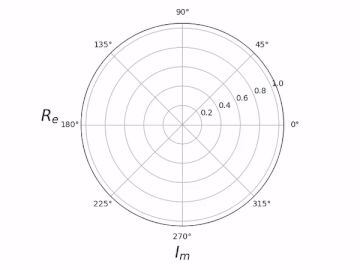

 ##### Faster

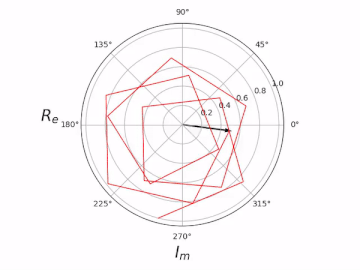

#### Suffice to say, the data is too complicated to understand in it's raw form
 
Spectral decomposition to the rescue (FFT)!

Fourier Series
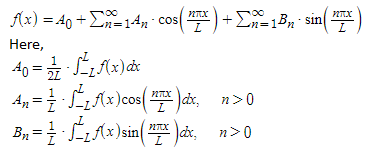

Text(0.5, 0, 'Chemical Shift (~ppm)')

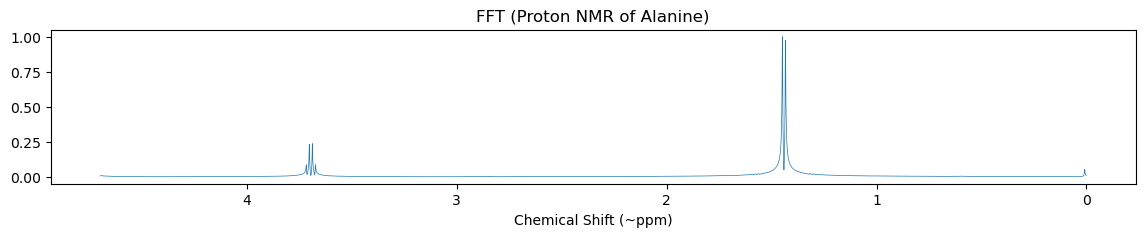

In [324]:
from numpy.fft import fft
X = fft(np.concatenate([np.zeros_like(fid),fid]))
# assume the whole experiment takes 1 second
sr = len(fid) #samples per second
N = len(X)
n = np.arange(N)
dw = 2 * np.pi / T #radians
T = N/sr #duration of signal (fft thinks entire dataset is one period)
freq = n/T # each point over full duration



plt.figure(figsize=(14, 2))
plt.plot(np.linspace(4.7,0,6600), (np.abs(X) / abs(X).max())[:6600], lw=0.5)
plt.title("FFT (Proton NMR of Alanine)")
plt.gca().invert_xaxis()
plt.xlabel("Chemical Shift (~ppm)")

 # Processed FFT

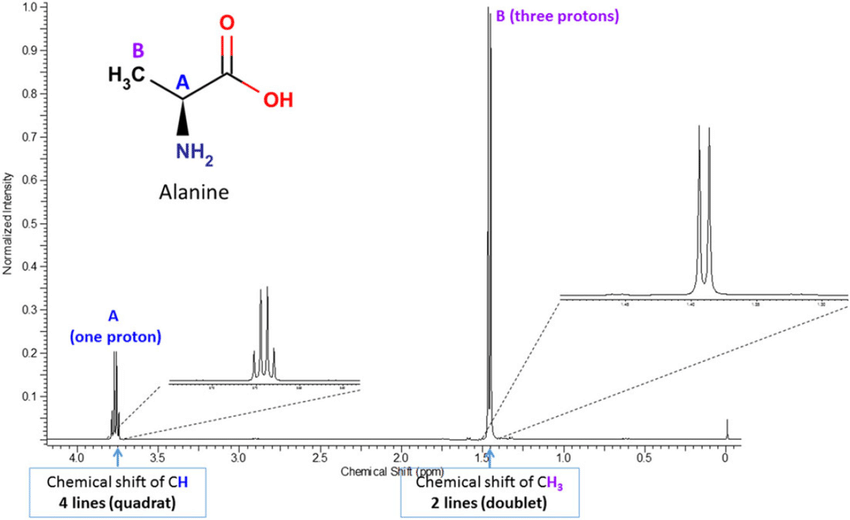

 # Let's see how spectral decomposition can be applied to multivariate DATA 

 #### x1 and x2 are uniformly distributed and independently sampled over [0, 1]
 #### x3 = to x1*10 + uniformly sampled noise (linearly correlated) sampled over [0, 1]

In [247]:
x1, x2 = (np.random.rand(100000) for i in range(2))
x3 = x1*10 + np.random.rand(100000)
x = np.stack([x1, x2, x3], 1)
n = len(x)
x_mu = x - x.mean(0)
x_std = x_mu / x_mu.std(0)
cov = x_mu.T @ x_mu / n
corr = x_std.T @ x_std / n

Text(0.5, 1.2, 'Relationships between our variables')

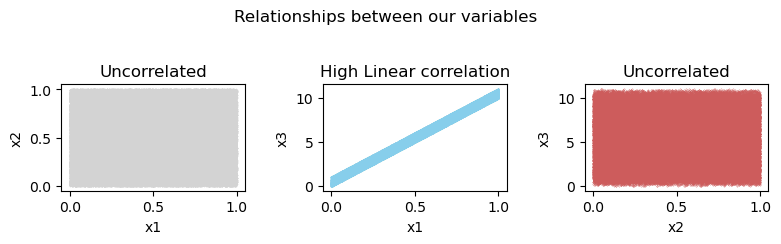

In [248]:
fig, axes = plt.subplots(1,3, figsize=(8,2))
colors = ["lightgray", "skyblue", "indianred"]
labels = [f"x{i}" for i in range(1,4)]
titles = ["Uncorrelated", "High Linear correlation", "Uncorrelated"]
for ax, color, index, title in zip(axes.flat,
                                   colors,
                                   np.stack(np.triu_indices(3, 1), 1),
                                   titles):
    i, j = index
    ax.scatter(x[:,i], x[:,j], color=color, s=0.05)
    ax.set_xlabel(labels[i])
    ax.set_ylabel(labels[j])
    ax.set_title(title)
fig.tight_layout()
fig.suptitle("Relationships between our variables", y=1.2)

  #### X = (n (samples), d (variables)) matrix with columns of data vectors
  
  $X = [\vec{x_{i}}, ..., \vec{x_{d}}]$
  ### We often work with mean free and unit variance data :
  $X_{\mu} = X - \frac{1}{n} \mathbb{1} X$
  
  $X_{\sigma} = X_{\mu}diag(\frac{1}{\sigma_{x_{i}}}$)
  #### The Graham matrix is defined as,
  $ G_{XX} = X^{T}X$
  #### This is highly similar to the covariance matrix, 
  $Cov = \frac{1}{n}X_{\mu}^{T}X_{\mu}$
  #### and correlation matrix, 
  $Corr = \frac{1}{n}X_{\sigma}^{T} X_{\sigma}$

The Graham, covariance and correlation matrices are weighted / shifted versions of eachother and are all used in various contexts. The choice of standardization  depends on whether or not the solution needs to maintain the scale (variance)  and shift (mean) of the training data.
  
These matrices tell us how much each variable cares about the others and often come up in numericalal linear algebra because Graham matrices are square, symmetric and positive semidefinite; this gives them nice properties; they're also related to the approximation of a matrix via SVD
  
  $X^{T}X V=V\Sigma^{2}$
  
  $X^{T}X =V\Sigma^{2} V^{T}$
  
  $UXX^{T} =U\Sigma^{2}$
  
  $XX^{T} =U\Sigma^{2} U^{T}$

  $X = U\Sigma V^{T} = \Sigma \vec{u}_{i} \sigma_{i} \vec{v}_{i}^{T}$

/tmp/ipykernel_3073/1006820332.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


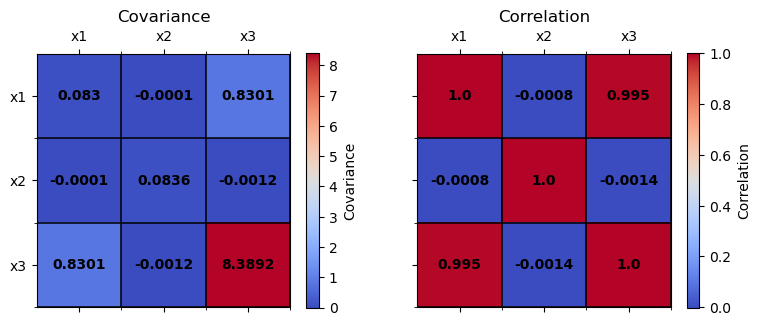

In [249]:
fig, axes = plt.subplots(1,2, figsize=(9,3.3), sharex=True, sharey=True)
ind = 0
titles = ["Covariance", "Correlation"]
for mat, ax, title in zip(np.stack([cov, corr]), axes.flat, titles):
    s=ax.matshow(mat, cmap="coolwarm")
    for i in range(len(mat)):
        for j in range(mat.shape[1]):
            c = mat[i, j]
            ax.text(j, i, f"{np.round(c, 4)}",
                    va='center', ha='center',
                    color="black",size=10,
                    weight="bold")
   

    ax.set_title(title)
    plt.colorbar(s, ax=ax, label=title)

    ax.set_xticks([x-0.5 for x in range(1,4)], minor=True)
    ax.set_yticks([y-0.5 for y in range(1,4)], minor=True)
    ax.set_xticklabels(labels)
    
    #plot grid on minor axes
    ax.grid(which ="minor", c='black', ls='-', lw='1.1', fillstyle=None)
    
    ax.set_xticks(np.arange(3), labels)
    ax.set_yticks(np.arange(3), labels)
    

 ### Notice that the scaling of the data impacts the covariance matrix but not the correlation matrix. This is often desirable or required. We may not want a particular feature to be emphasized because of it's scale alone.

 # Covariance spectrum

 The Covariance matrix has nice properties as it is atleast Symmetric Positive Semi-Definite.
 If there are no redundant features in the dataset, it's Symmetric Positive Definite
 As a consequence, the eigen and singular values are the same (see below)

eigen values [8.47137109e+00 8.35813427e-02 8.12675055e-04]
singular values [8.47137109e+00 8.35813427e-02 8.12675055e-04]


 Sum of either the singular or eigen values == tr(Cov)
 This is a boring fact with a cool interpretation : 
 the eigen functions each capture a fraction of the variance,
 if we use all of them, we reconstruct the dataset in the eigen basis and lose no information

 8.555765104482294 == 8.555765104482294 

 However, we usually hope that only a few eigen functions capture the most important aspects of the data
 If this is true, we can get very interpretable, low dimensional representations of the data
 Compressing the information of a dataset into the lowest dimensional representation possible is a goal of datascien

Text(0.5, 0, 'Index')

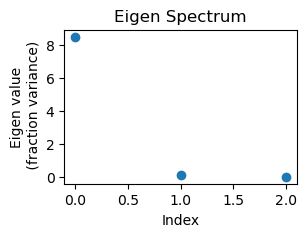

In [255]:
l, v = np.linalg.eig(cov)
idx = l.argsort()[::-1]
l, v = l[idx], v[:, idx]
u, s, vt = np.linalg.svd(cov)

print(" The Covariance matrix has nice properties as it is atleast Symmetric Positive Semi-Definite.\n",
     "If there are no redundant features in the dataset, it's Symmetric Positive Definite\n",
     "As a consequence, the eigen and singular values are the same (see below)\n")
print(f"eigen values {l}")
print(f"singular values {s}\n\n")
print(f" Sum of either the singular or eigen values == tr(Cov)\n",
      "This is a boring fact with a cool interpretation : \n",
      "the eigen functions each capture a fraction of the variance,\n",
      "if we use all of them, we reconstruct the dataset in the eigen basis and lose no information\n\n",
       np.trace(cov),"==", f"{l.sum()} \n\n",
      "However, we usually hope that only a few eigen functions capture the most important aspects of the data\n",
      "If this is true, we can get very interpretable, low dimensional representations of the data\n",
      "Compressing the information of a dataset into the lowest dimensional representation possible is a goal of datascience.\n",
      "BUT we have to be careful with this idea, if our data is complicated (high information content)\n",
      "then reducing the dimension can remove crucial information : this is a central challenge in information theory.\n",
      "Google 'lossy compression vs. lossless compression' for more details "
     )
plt.figure(figsize=(3,2))
plt.scatter(np.arange(3),l)
plt.title("Eigen Spectrum")
plt.ylabel("Eigen value\n (fraction variance)")
plt.xlabel("Index")

We see the only interesting relationship in our data (x1 and x3) is captured by the first eigen function. Inspecting the Eigen function shows that variables x1 and x3 contribute the most to the linear combination (index 0 and 2)

Same story for the correlation matrix except the trace of the correlation matrix == 3 because each standardized variable has variance == 1.

In [251]:
l, v = np.linalg.eigh(corr)
idx = l.argsort()[::-1]
l, v = l[idx], v[:, idx]
u, s, vt = np.linalg.svd(corr)
print(f"eigen values {l}")
print(f"singular values {s}")

eigen values [1.99504366 0.99999775 0.00495859]
singular values [1.99504366 0.99999775 0.00495859]


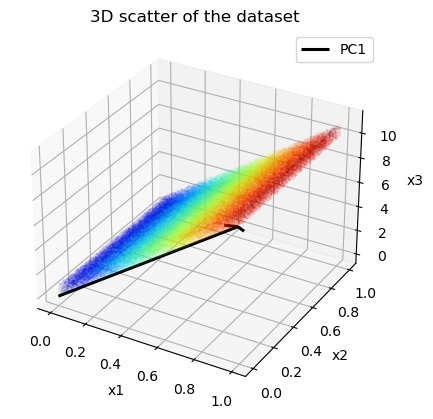

In [256]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.scatter(*x.T, s=0.05, c=x_mu[:,2], cmap="jet", alpha=.1)
for i, xyz in enumerate(["x", "y", "z"]):
    getattr(ax, f"set_{xyz}label")(f'x{i+1}', size=10)
    
ax.quiver(0,0,0,
              -v.T[0][0].flatten(),
              -v.T[0][1].flatten(),
              -v.T[0][2].flatten(),
              capstyle="butt",
              length=10,
          lw=2.2,
          
          arrow_length_ratio=.02,
          color="black",
          label = "PC1",
     )    

ax.set_title("3D scatter of the dataset")
ax.legend()
plt.show()

 ### Let's try to understand the eigen functions of the covariance matrix by comparing them with the co-efficients we get from a linear regression

 #### The linear regression problem
 $X\vec{w} = Y$
 
 $\vec{w} = (X^{T}X)^{-1}X^{T}Y = C_{XX}^{-1}C_{XY}$
 
 ##### We can preferably use the Singular Value Decomposition of X to compute linear regression 
 
 $X = U \Sigma V^{T}$
 ##### U and V are unitary matrices and $\Sigma$ is diagonal, thus ...
 $V^{T}V = VV^{T} = U^{T}U = UU^{T} = I$
 
 $U \Sigma V^{T} \vec{w} = Y$
 
 $V\Sigma^{-1}U^{T} U \Sigma V^{T} \vec{w} = V\Sigma^{-1}U^{T} Y$
 
 $V\Sigma^{-1}I\Sigma V^{T} \vec{w} = V\Sigma^{-1}U^{T} Y$
 
 $V I V^{T} \vec{w} = V\Sigma^{-1}U^{T} Y$
 
 $\vec{w} = V\Sigma^{-1}U^{T} Y$
 




 #### The transformation, f, is just the concatenation (||) of a column of ones. This let's us learn the "y-intercept"  in our (affine) linear model
$f(X) = [X || \vec{1}]$

$w = (f(X)^{T}f(X))^{-1}f(X)^{T}Y = C_{f(X)f(X)}^{-1}C_{f(X)Y}$


In [360]:
# first way is old school 
X = np.stack([x1, np.ones_like(x1)], 1) # sometimes called precision matrix

weights = np.linalg.inv(X.T @ X) @ X.T @ x3.reshape(-1,1)

# go SVD style for sudo-inverse
u, s, vt = np.linalg.svd(X, full_matrices=False)

weights_svd = vt.T @ np.diag(1/s) @ u.T @ x3.reshape(-1,1)

print("The first weight is the slope and the second is the intercept\n")
print("weights using inverse\n", weights)
print("weights using SVD\n", weights_svd)

The first weight is the slope and the second is the intercept

weights using inverse
 [[10.00651951]
 [ 0.49545082]]
weights using SVD
 [[10.00651951]
 [ 0.49545082]]


We have a slope of 10 by construction. we wrote x3 = x1*10 + uniform(0,1). We have an intercept of 1 / 2 because is it the expectation value of a uniform random variable sampled over : [0, 1]

Linear Regression (x1 = x3 * m + b) provides a better fit for x1 and x3 in isolation because we add an additional parameter, b, to account for the y-intercept (mean).
 


Text(0.5, 1.0, 'Linear regression and PCA find the same slope')

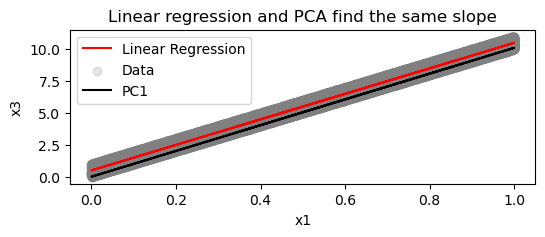

In [270]:
plt.figure(figsize=(6,2))
plt.plot(x1, X @ weights, c="red", label="Linear Regression")
plt.scatter(x1, x3, alpha=.2, c="grey", label="Data")
plt.plot(x1, x1 * v.T[0][2] / v.T[0][0], color="black",label="PC1" )
plt.xlabel("x1")
plt.ylabel("x3")
plt.legend()
plt.title("Linear regression and PCA find the same slope")

 # The Kernel "trick"

Our linear regression gave a better description on the relationship between x1 and x3 because we used an additional parameter (the y-intercept in linear model). Using a transformation of a dataset that maps to a higher dimension allows us to tune the complexity of our model (warning: BIAS VARIANCE TRADE OFF, OVERFITTING, ECT). The "trick" is that after we learn a complex model in a high dimensional space, we can still map back to the dimension we started in; also, we can learn a nonlinear function using a linear model. Concatenating a column of ones (as done in the regression problem) is an example of a possible f(x) one might choose (linear kernel) to use in ...

$w = (f(X)^{T}f(X))^{-1}f(X)^{T}Y = C_{f(X)f(X)}^{-1}C_{f(X)Y}$

##### in the following example, we'll use a polynomial as our f(X) with n = 3 (third degree polynomial)
$f(X) = \Sigma_{j}^{n} x^{j}$
 
 #### Kernels, transformations to "latent" spaces and change of basis are common in data science
 
Here is the general form of a regression equation in which transformations are used for both X and Y.

$w_{K} = (f(X)^{T}f(X))^{-1}f(X)^{T}g(Y) = K_{xx}^{-1}K_{xy}$

So, 

$f(X) K_{xx}^{-1}K_{xy} \approx g(Y)\ (Koopman\  operator)$

In particular, kernel methods attempt to leverage the fact that we can implicitly express our covariance matrices in a different (higher dimensional) inner product space.(search reproducing kernel Hilbert space for a more rigorous description of kernels in this context).


$K_{x_{i}, x_{j}} = <f(\vec{x_{i}})|f(\vec{x_{j}})>\ (inner\ product)\ or\ k(x_{i}, x_{j})\ (function)$

$K_{x_{i}, y_{j}} = <f(\vec{x_{i}})|g(\vec{y_{j}}))>\ (inner\ product)\ or\ k(x_{i}, y_{j})\ (function)$

#### the function, g(y), must either be the identity transformation or a transformation that maps to the same dimension as y if a solution in the space of the original data is the objective. 

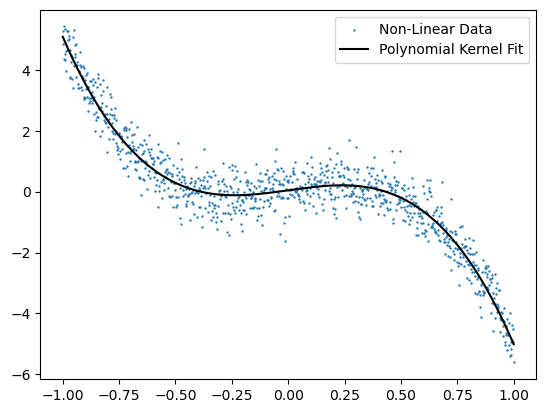

In [359]:
from numpy.linalg import inv
# make noisey dataset
x = np.linspace(-1, 1, 1000)
y = -6 * np.power(x, 3) + (1/25) * np.power(x, 2) + x + np.random.randn(1000) / 2
plt.scatter(x, y, s= 0.5, label="Non-Linear Data")


# quick implementation of polyfitting 
polykernel = lambda x, degree : np.stack([np.power(x.flatten(), i) for i in range(degree+1)], 1)
fX = polykernel(x, 3)
w = inv(fX.T @ fX) @ fX.T @ y
###


plt.plot(x, fX @ w, color="black", label="Polynomial Kernel Fit")
plt.legend()

# Likelihood and Maximum Likelihood Estimation

The normal density function is given by,
$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}\left(
    \frac{x-\mu}{\sigma} \right)^2}
$$

The likelihood of of an observed x-value, say $x_1$ is simply $\mathscr{l} = f(x_1)$.  If there are multple x-values, $x_1, x_2, x_3, \cdots , x_N$, the the likelihood is given py the product of the individual likelihoods,
$$
\mathscr{l} = \prod_{i=1}^N f(x_i)
$$

We want to find $\mu$ and $\sigma$ given a bunch of x-values and assuming a normal distribution.  We do this my choosing $\mu$ and $\sigma$ as to maximize the likelihood.  In practice, one actually maximizes the log of the likelihood as this doesn't affect the estiamted values of our unknown parameters, but does simplify the calculation, both analytically and numerically.

See the Wikipedia article on maximum likelihood and the derivation for the normal distribution:  https://en.wikipedia.org/wiki/Maximum_likelihood_estimation#Continuous_distribution,_continuous_parameter_space


We find the maximum by setting the derivatives equal to zero:

$$\frac{d\ln(\mathscr{l})}{d\mu} = 0$$
and
$$
\frac{d\ln(\mathscr{l})}{d\sigma} = 0
$$

If we solve these we get,
$$
\mu^* = \frac{1}{N}\sum^N_{i = 1} x_i
$$
and
$$\sigma^* = \sqrt{
\frac{1}{N}\sum^N_{i=1} (x_i - \mu^*)^2}
$$

The results for the normal distribution turn out to be the sample mean and standard deviation

target mean : 3.8531320020313258
target S.D 4.080537077184628

results

      fun: 28251.671495333587
     jac: array([0.00073242, 0.01611328])
 message: 'Optimization terminated successfully'
    nfev: 182
     nit: 50
    njev: 46
  status: 0
 success: True
       x: array([3.85313325, 4.08055064])


/tmp/ipykernel_16376/1692018183.py:10: RuntimeWarning: divide by zero encountered in log
  l = np.sum(np.log(norm.pdf(x, loc = mu, scale = sigma)))


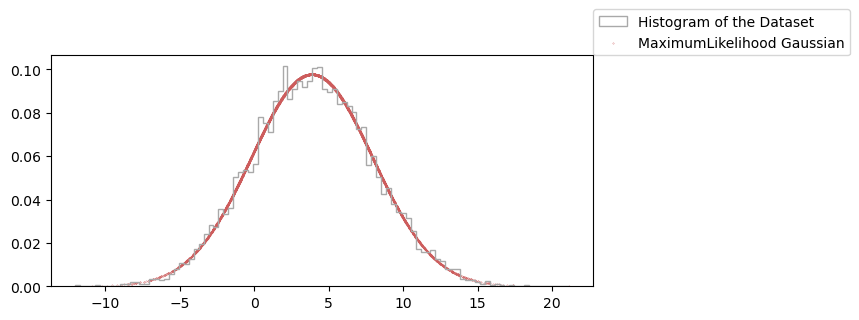

In [81]:
import scipy
from scipy.stats import norm
from scipy.optimize import minimize

def log_likelihood(p, x):
    """p : parameters , [mu, sigma],
       x : values to evaluate the likelihood of"""
    mu = p[0]
    sigma = p[1]
    l = np.sum(np.log(norm.pdf(x, loc = mu, scale = sigma)))
    return -l 

def constraint(p):
    #constrain sigma to be positive
    sigma = p[1]
    return sigma

#sample data with uniform noise

np.random.seed(123)
N = 10000
x = np.random.normal(loc = 2.3, scale = 4, size = (N,)) + np.random.rand(N) * 3
print("target mean :", np.mean(x))
print("target S.D", np.std(x))
#plot sample
plt.figure(figsize=(7,3))
plt.hist(x,
         bins=100,
         histtype="step",
         color="darkgrey",
         density=True,
         label="Histogram of the Dataset")


#optimize

cons = {'type':'ineq', 'fun': constraint}
p0 = [0, 1]
result = minimize(log_likelihood, p0, args=(x,), constraints=cons)
print("\nresults\n\n", result, )

# plot inferred distribution

plt.scatter(x, 
            scipy.stats.norm.pdf(x, loc=result.x[0], scale=result.x[-1]),
            s=0.05,
            label="MaximumLikelihood Gaussian",
            color="indianred")

plt.legend(loc=[1,1])

 # Let's take a first shot at traning common neural net architectures for classification tasks

Text(0.5, 0.98, 'Downsampled images of hand written Digits')

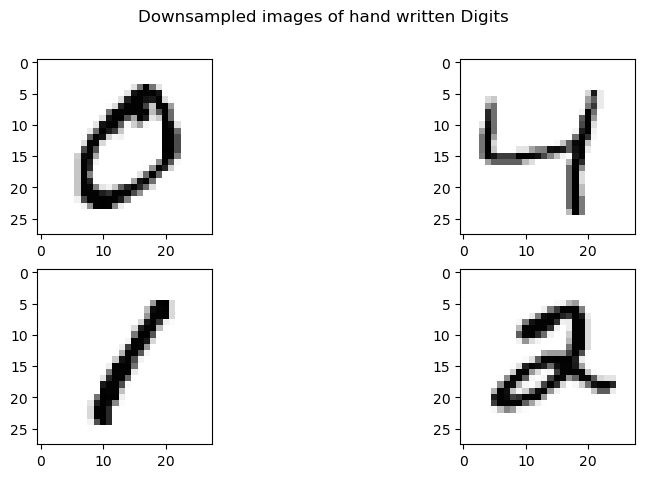

In [9]:
from tensorflow.keras.datasets import mnist

def get_mnist(n_classes):
    train, test = mnist.load_data()
    train_idx = np.isin(train[-1], np.arange(n_classes))
    test_idx = np.isin(test[-1], np.arange(n_classes))
    train, test = list(i[train_idx] for i in train), list(i[test_idx] for i in test)
    norm = max(map(np.max, (train[0], test[0])))
    train[0], test[0] = train[0] / norm, test[0] / norm
    return train, test

# from PIL import Image

# def resize(x: np.ndarray, shape: tuple):
#     return np.asarray(Image.fromarray(x).resize(shape))

# def iter_resize(x: np.ndarray, shape: tuple):
#     return np.stack([resize(i, shape) for i in x])
    
#shape = (24,24)
images = get_mnist(n_classes=5)[0][0][:4]
#test_data, test_labels = test
fig, axes = plt.subplots(2,2, figsize=(10, 5))
for ax, image in zip(axes.flat, images):
    ax.imshow(image, cmap="Greys")
fig.suptitle("Downsampled images of hand written Digits")

  # Logistic Regression: using a single "neuron"
 
 ### We want to teach an algorithm to tell us what number is written in each image
 
 #### First we'll do it with just ones and zeros (two class problem). This isn't a particularly difficult task because 1 and zero are quite distinct. 
 #### We will then repeat but with numbers 0-9 (multi-class problem)
 

 

In [73]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from itertools import chain

class LogisticRegression(nn.Module):
    
    def __init__(self, in_dim: int=784, out_dim: int=1, n_layers: int=1):
        super().__init__()
        
        self.loss = torch.nn.BCELoss() if out_dim == 1 else\
                    lambda x, y : torch.mean(-torch.log((x * y).sum(1)))
        
        activation = nn.Sigmoid() if out_dim == 1 else nn.Softmax(dim=1)
        
        if n_layers > 1:   
            dims = [int(in_dim // (i + 1)) for i in range(n_layers)]
            hidden = list(*chain([(nn.Linear(i, j), nn.GELU()) for i, j in zip(dims[:-1], dims[1:])]
                                )
                         )
        else:
            hidden = [nn.Identity()]

        output = [nn.LazyLinear(out_dim),
                  activation,
                  nn.Flatten(start_dim=0 if out_dim == 1 else 1)]

        self.neuron = nn.Sequential(*(hidden+output))
    
    def forward(self, x):
        return self.neuron(x)
    
def dirac_delta(x, states=None, weights=None):
    "'one hot' encoding of a (time) series of labels into a (n_samples, n_labels) binary matrix"
    states = np.unique(x) if states is None else states
    x, states = (i.astype(int) for i in (x, states))
    impulse = (x.flatten() == states.reshape(-1, 1)).astype(float)
    return (impulse if weights is None else impulse * weights.reshape(1, -1)).T
    
def accuracy(x, y):
    
    x, y = (i.detach().numpy().squeeze() for i in (x, y))
    
    if x.ndim > 1:
        return np.mean(x.argmax(1) == y.argmax(1))
    else:
        x, y = (x>0.5).astype(int), y.astype(int)
        return np.mean(x == y)
    
class DataSet(Dataset):
    
    def __init__(self, data: torch.Tensor, labels: torch.Tensor):
        super().__init__()
        
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).float()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
def fetch_datasets(n_classes, batch_size:int = 32):

    train, test = get_mnist(n_classes=n_classes)
    train_data, train_labels, test_data, test_labels = *train, *test
    
    train_data, test_data = (i.reshape(-1, 28*28) for i in (train_data, test_data))
    
    if n_classes > 2:
        train_labels, test_labels = (dirac_delta(i) for i in (train_labels, test_labels))
    
    train_dataset, test_dataset = (DataSet(train_data, train_labels),
                                   DataSet(test_data, test_labels)
                                   )
                                  
    return (train_dataset,
            DataLoader(train_dataset, batch_size=32, shuffle=True),                  
            test_dataset,
            DataLoader(test_dataset, batch_size=len(test_data), shuffle=False),
           )



 # Let's train

In [74]:
def train_model(model, train_loader, test_loader, epochs, optim):
    x, y = next(iter(test_loader))
    fx = model(x)
    loss = model.loss(fx, y)
    print(f"PRETRAIN Loss : {loss.item()}, PRETRAIN Accuracy : {accuracy(fx, y)}")
    
    for _ in range(epochs):
        model.train()
        for batch in train_loader:
            optim.zero_grad()
            x, y = batch
            fx = model(x)
            loss = model.loss(fx, y)
            loss.backward()
            optim.step()

        model.eval()
        with torch.no_grad():
            x, y = next(iter(test_loader))
            fx = model(x)
            loss = model.loss(fx, y)
            print(f"Epoch: {_+1}, Loss : {loss.item()}, Accuracy : {accuracy(fx, y)}")

 # Two Classes (0's and 1's)
 
 ## We do very well on this task with the simplest model possible

In [79]:
train_dataset, train_loader, test_dataset, test_loader = fetch_datasets(n_classes=2)
neuron = LogisticRegression(out_dim=1)
optim = torch.optim.Adam(neuron.parameters(), lr=1e-3)
train_model(neuron, train_loader, test_loader, 3, optim)

PRETRAIN Loss : 0.6622602343559265, PRETRAIN Accuracy : 0.7049645390070922
Epoch: 1, Loss : 0.019196443259716034, Accuracy : 0.9995271867612293
Epoch: 2, Loss : 0.008870217017829418, Accuracy : 0.9995271867612293
Epoch: 3, Loss : 0.005663020070642233, Accuracy : 0.9995271867612293


 # Multiclass (9 classes)
 ## We don't do as well, how can we do better?

In [77]:
train_dataset, train_loader, test_dataset, test_loader = fetch_datasets(n_classes=9)
neuron = LogisticRegression(out_dim=9)
optim = torch.optim.Adam(neuron.parameters(), lr=1e-3)
train_model(neuron, train_loader, test_loader, 3, optim)

PRETRAIN Loss : 2.215913772583008, PRETRAIN Accuracy : 0.1272383494605717
Epoch: 1, Loss : 0.26055970788002014, Accuracy : 0.9288177065954843
Epoch: 2, Loss : 0.23483368754386902, Accuracy : 0.9358247136024914
Epoch: 3, Loss : 0.23057125508785248, Accuracy : 0.9356022689356023


 # 2 Layers
 # Here, we see a Multi Layer Perceptron
 
 #### a neuron can be represented as a transformation of our input $f : X \rightarrow X^{'}$
 $X^{'} = \alpha(XW + \beta)$
 
 ### $\alpha$ is nonlinear activation function whose argument is a trainable linear transformation of the input (X)
 
 ### To increase the descriptive capability of the model, we stack these neurons. In our particular case, we choose to reduce the dimension of the data by 1/2 in each "Hidden" layer. Hidden Layers are those between the input and output layers. In this case, we have 1 hidden layer.

In [72]:
neuron = LogisticRegression(out_dim=9, n_layers=2)
neuron

LogisticRegression(
  (neuron): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): GELU()
    (2): Linear(in_features=392, out_features=9, bias=True)
    (3): Softmax(dim=1)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
)

In [78]:
train_dataset, train_loader, test_dataset, test_loader = fetch_datasets(n_classes=9)
neuron = LogisticRegression(out_dim=9, n_layers=2)
optim = torch.optim.Adam(neuron.parameters(), lr=1e-3)
train_model(neuron, train_loader, test_loader, 3, optim)

PRETRAIN Loss : 2.191833734512329, PRETRAIN Accuracy : 0.13235457679902124
Epoch: 1, Loss : 0.08974435180425644, Accuracy : 0.9734178623067512
Epoch: 2, Loss : 0.06878004968166351, Accuracy : 0.9782004226448671
Epoch: 3, Loss : 0.06445806473493576, Accuracy : 0.9802024246468691


 # More layers == more better ;p